# モデル評価

## 分割表(contingency table)

<table>
    <tr>
        <th></th>
        <th>Cに属する</th>
        <th>Cに属さない</th>
    </tr>
    <tr>
        <td>Cであると予測</td>
        <td>a(True Positive: TP)</td>
        <td>b(False Positive: FP)</td>
    </tr>
    <tr>
        <td>Cでないと予測</td>
        <td>c(False Negative: FN)</td>
        <td>d(True Negative: TN)</td>
    </tr>
</table>

## 評価指標

 - 偽陽性率(false positive rate) : $\frac {b}{b + d}$
 - 真陽性率(true positive rate) : $\frac {a}{a + b}$
 - 適合率(precision) : $\frac {a}{a + b}$
 - 再現率(recall) : $\frac {a}{a + c}$
 - F値(F-measure) : $\frac {2 \times precision \times recall}{precision + recall}$
 - 正確度(accuracy) : $\frac {a + d}{a + b + c + d}$

## ROC曲線

## AUC曲線

---
# 実装

In [54]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントを設定
font = {'family': 'IPAexGothic'}
mpl.rc('font', **font)

%matplotlib inline

## データセットの読み込み
**乳がんデータ（Breast cancer wisconsin [diagnostic] dataset）**<br>
> 乳がんの診断データがまとめられたデータセットです。各ケースは検査値を含む32の値を持っており、変数の多いデータセットになっています。各ケースには、良性腫瘍か悪性腫瘍の診断結果が付いており、これを目的変数とする分類学習になります。

In [55]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

dataset_df = pd.DataFrame(cancer.data, columns=[['features' for i in cancer.feature_names], cancer.feature_names])
dataset_df[('teacher', 'is_positive')] = cancer.target
dataset_df.head()

features                                                        \
  mean radius mean texture mean perimeter mean area mean smoothness   
0       17.99        10.38         122.80    1001.0         0.11840   
1       20.57        17.77         132.90    1326.0         0.08474   
2       19.69        21.25         130.00    1203.0         0.10960   
3       11.42        20.38          77.58     386.1         0.14250   
4       20.29        14.34         135.10    1297.0         0.10030   

                                                                     \
  mean compactness mean concavity mean concave points mean symmetry   
0          0.27760         0.3001             0.14710        0.2419   
1          0.07864         0.0869             0.07017        0.1812   
2          0.15990         0.1974             0.12790        0.2069   
3          0.28390         0.2414             0.10520        0.2597   
4          0.13280         0.1980             0.10430        0.1809   

                          ...                                           \
  mean fractal dimension  ... worst texture worst perimeter worst area   
0                0.07871  ...         17.33          184.60     2019.0   
1                0.05667  ...         23.41          158.80     1956.0   
2                0.05999  ...         25.53          152.50     1709.0   
3                0.09744  ...         26.50           98.87      567.7   
4                0.05883  ...         16.67          152.20     1575.0   

                                                                           \
  worst smoothness worst compactness worst concavity worst concave points   
0           0.1622            0.6656          0.7119               0.2654   
1           0.1238            0.1866          0.2416               0.1860   
2           0.1444            0.4245          0.4504               0.2430   
3           0.2098            0.8663          0.6869               0.2575   
4           0.1374            0.2050          0.4000               0.1625   

                                             teacher  
  worst symmetry worst fractal dimension is_positive  
0         0.4601                 0.11890           0  
1         0.2750                 0.08902           0  
2         0.3613                 0.08758           0  
3         0.6638                 0.17300           0  
4         0.2364                 0.07678           0  

[5 rows x 31 columns]

## モデリング

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    StandardScaler().fit_transform(dataset_df.features), 
    dataset_df.teacher, 
    test_size=0.3, train_size=0.7, random_state=0
)

classifier = LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')
classifier.fit(x_train, y_train)

/Users/taiyou/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## 評価

In [97]:
import pandas as pd

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


class ContingencyTable(pd.DataFrame):
    
    def __init__(self, y_test, y_pred, y_proba):
        super().__init__(
            confusion_matrix(y_test, y_pred),
            index=['正でない', '正である'],
            columns=['正でないと予測', '正であると予測']
        )
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_proba = y_proba
    
    def metrics(self):
        return pd.Series(
            (
                int(y_test.shape[0]),
                (分割表.loc['Cである'].sum() / y_test.shape[0]).round(3),
                (分割表.loc['Cでない'].sum() / y_test.shape[0]).round(3),
                (分割表.loc['Cでない', 'Cであると予測'] / 分割表.loc['Cでない'].sum()).round(3),
                (分割表.loc['Cである', 'Cであると予測'] / 分割表.loc['Cである'].sum()).round(3),
                accuracy_score(y_test, y_pred).round(3),
                precision_score(y_test, y_pred).round(3),
                recall_score(y_test, y_pred).round(3),
                f1_score(y_test, y_pred).round(3)
            ), 
            index=[
                '評価データサイズ', '正率', '負率',
                '偽陽性率(false positive rate)', 
                '真陽性率(true positive rate)', 
                '正確度(accuracy)', 
                '適合率(precision)', 
                '再現率(recall)', 
                'F値(F-measure)'
            ], 
            name='分類モデルの評価'
        )

    def roc_curve(self):
        pass
    
    def RP_curve(self):
        pass

In [99]:
ContingencyTable(y_test, y_pred, classifier.predict_proba(x_test)[:, 1]).metrics()

/Users/taiyou/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/Users/taiyou/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app
/Users/taiyou/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


評価データサイズ                     171.000
正率                             0.632
負率                             0.368
偽陽性率(false positive rate)      0.048
真陽性率(true positive rate)       0.944
正確度(accuracy)                  0.947
適合率(precision)                 0.971
再現率(recall)                    0.944
F値(F-measure)                  0.958
Name: 分類モデルの評価, dtype: float64

In [62]:
y_pred = classifier.predict(x_test)
y_proba = classifier.predict_proba(x_test)

### 分割表

In [58]:
from sklearn.metrics import confusion_matrix

分割表 = pd.DataFrame(
    confusion_matrix(y_test, y_pred), 
    index=['Cでない', 'Cである'], 
    columns=['Cでないと予測', 'Cであると予測']
)
分割表

,Cでないと予測,Cであると予測
Cでない,60,3
Cである,6,102


### 評価指標

In [120]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


pd.Series(
    (
        int(y_test.shape[0]),
        (分割表.loc['Cである'].sum() / y_test.shape[0]).round(3),
        (分割表.loc['Cでない'].sum() / y_test.shape[0]).round(3),
        (分割表.loc['Cでない', 'Cであると予測'] / 分割表.loc['Cでない'].sum()).round(3),
        (分割表.loc['Cである', 'Cであると予測'] / 分割表.loc['Cである'].sum()).round(3),
        accuracy_score(y_test, y_pred).round(3),
        precision_score(y_test, y_pred).round(3),
        recall_score(y_test, y_pred).round(3),
        f1_score(y_test, y_pred).round(3)
    ), 
    index=[
        '評価データサイズ', '正率', '負率',
        '偽陽性率(false positive rate)', 
        '真陽性率(true positive rate)', 
        '正確度(accuracy)', '適合率(precision)', 
        '再現率(recall)', 'F値(F-measure)'
    ], 
    name='クラス分類モデルの評価'
)

評価データサイズ                     171.000
正率                             0.632
負率                             0.368
偽陽性率(false positive rate)      0.048
真陽性率(true positive rate)       0.944
正確度(accuracy)                  0.947
適合率(precision)                 0.971
再現率(recall)                    0.944
F値(F-measure)                  0.958
Name: クラス分類モデルの評価, dtype: float64

### ROC曲線

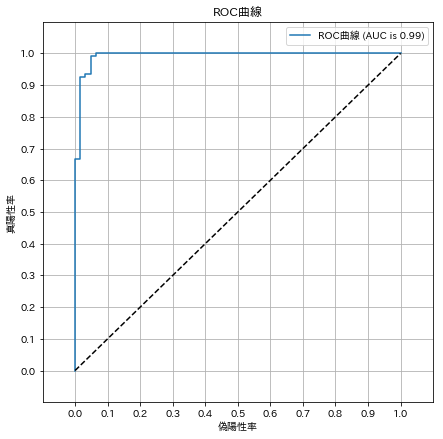

In [115]:
from sklearn.metrics import auc, roc_curve

偽陽性率, 真陽性率, 閾値 = roc_curve(y_test, y_proba[:, 1])
AUC = auc(偽陽性率, 真陽性率)

plt.figure(figsize=(7, 7))
plt.title('ROC曲線')

plt.plot(偽陽性率, 真陽性率, label='ROC曲線 (AUC is %.2f)' % AUC)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('偽陽性率')
plt.ylabel('真陽性率')

plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))

plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))

plt.legend()
plt.grid(True)
plt.show()

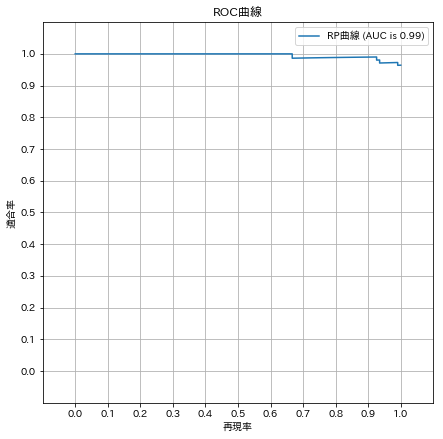

In [121]:
from sklearn.metrics import auc, precision_recall_curve


適合率, 再現率, 閾値 = precision_recall_curve(y_test, y_proba[:, 1])
AUC = auc(再現率, 適合率)

plt.figure(figsize=(7, 7))
plt.title('ROC曲線')

plt.plot(再現率, 適合率, label='RP曲線 (AUC is %.2f)' % AUC)

plt.xlabel('再現率')
plt.ylabel('適合率')

plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))

plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))

plt.legend()
plt.grid(True)
plt.show()

In [146]:
from sklearn.metrics import recall_score, precision_score
from tqdm import tqdm

適合率_list = []
再現率_list = []
刻み = 0.01
for 閾値 in tqdm(np.arange(0.0 + 刻み, 1.0 + 刻み, 刻み)):
    確率 = (classifier.predict_proba(x_test)[:, 1] >= 閾値).astype(int)
    適合率 = precision_score(y_test, 確率)
    再現率 = recall_score(y_test, 確率)
    
    適合率_list.append(適合率)
    再現率_list.append(再現率)

 91%|█████████ | 91/100 [00:00<00:00, 403.78it/s]/Users/taiyou/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 100/100 [00:00<00:00, 446.01it/s]


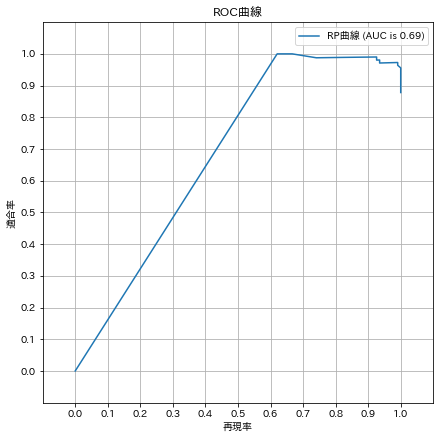

In [153]:
from sklearn.metrics import auc


AUC = auc(再現率_list, 適合率_list)

plt.figure(figsize=(7, 7))
plt.title('ROC曲線')

plt.plot(再現率_list, 適合率_list, label='RP曲線 (AUC is %.2f)' % AUC)
plt.xlabel('再現率')
plt.ylabel('適合率')

plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))

plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))

plt.legend()
plt.grid(True)
plt.show()